# Perform Classification on the ADNI dataset using SVMs, after MCA & DCCA

## Importing Stuff:

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

import pickle
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

## Read the data:

Instead of reading the whole database, we read only the data that's useful to us. That is, we read only specific columns of data, and we take only the row containing the first scan for each person. 

In "ADNI Regressional Analysis.ipynb" we have done that exactly, as well as performed linear regression transformation to the imaging data, in order to remove any age, sex, and DLICV_baseline effect. 

Furthermore, in "ADNI DCCA with OPNMF.ipynb" we have previously performed dimensionality reduction through the OPNMF method, reducing the number of dimensions for the imaging data to just 30.

Additionally, in "ADNI DCCA with OPNMF.ipynb" we have transformed the imaging and the genetic data using Deep Canonical Correlation Analysis to dimensionally reduced, maximally linearly correlated data. 

The data is located at "./DATA/ADNI_dataset.csv"
The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl"
The data that was used for the DCCA with OPNMF is at "./DATA/OPNMF_DCCA_data.pkl"

(Need to run the RA and DCCA code if data is not found)

In [2]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head()

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2


In [3]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
dcca_data = lr_data.drop(labels = columns_to_drop, axis=1)

# Read the data transformed through DCCA:
with open("./DATA/MCA_DCCA_outputs.pkl", 'rb') as f:
    dcca_transformed_data_file = pickle.load(f)
transformed_imaging_data = dcca_transformed_data_file[0]
transformed_genetic_data = dcca_transformed_data_file[1]
print("Transformed imaging data dimensions: \n" , transformed_imaging_data.shape)
print("Transformed genetic data dimensions: \n" , transformed_genetic_data.shape)

# Embed them into the new dataset:
imaging_labels = ["imaging_component_"+str(x+1) for x in range(transformed_imaging_data.shape[1])] 
genetic_labels = ["genetic_component_"+str(x+1) for x in range(transformed_genetic_data.shape[1])] 
dcca_data[genetic_labels] = transformed_genetic_data
dcca_data[imaging_labels] = transformed_imaging_data
print("DCCA Data Dimensions: \n",dcca_data.shape)
dcca_data.head()

Transformed imaging data dimensions: 
 (1302, 150)
Transformed genetic data dimensions: 
 (1302, 150)
DCCA Data Dimensions: 
 (1302, 310)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,...,imaging_component_141,imaging_component_142,imaging_component_143,imaging_component_144,imaging_component_145,imaging_component_146,imaging_component_147,imaging_component_148,imaging_component_149,imaging_component_150
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,...,0.991986,-15.197325,13.987051,0.280044,-14.724760,6.037100,15.896213,9.093044,-12.119327,-9.300970
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,...,0.434874,-15.113810,13.904093,1.522299,-15.769327,5.156594,15.363470,9.554826,-11.601482,-6.403308
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,...,1.177222,-14.891131,12.314053,1.644624,-15.767372,5.532053,12.083865,12.130998,-11.517179,-10.742541
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,...,1.815794,15.584515,-12.341055,-0.648647,18.520105,-12.481134,-20.515711,-13.690228,11.798060,14.365234
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,...,0.751206,-13.202568,13.106786,2.910506,-17.922320,5.856430,12.711363,10.478322,-8.806449,-5.748745


## Perform Classification using SVMs:

In [4]:
def perform_svm(X,Y,kern= None, model=svm.LinearSVC(), params=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)
    
    
    clf = GridSearchCV(model, params, n_jobs=-1, cv=5)
    clf.fit(X_train,Y_train)
    print("Best Parameters for untrained data (",kern," kernel):",clf.best_params_)
    pred =  clf.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred, normalize='true')
    bal_acc = balanced_accuracy_score(Y_test, pred)
    if kern == None:
        print('Accuracy (Linear Kernel): ', "%.2f" % (acc*100))
        print('Balanced Accuracy (Linear Kernel): ', "%.2f" % (bal_acc*100))
        print('F1 (Linear Kernel): ', "%.2f" % (f1*100))
    else:
        print('Accuracy ('+kern+' Kernel): ', "%.2f" % (acc*100))
        print('Balanced Accuracy ('+kern+' Kernel): ', "%.2f" % (bal_acc*100))
        print('F1 ('+kern+' Kernel): ', "%.2f" % (f1*100))       
    return acc, f1, np.around(cm, decimals=2), bal_acc

In [5]:
Accuracies = []
F1s = []
Balanced_Accuracies = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

l, p, r = svm.LinearSVC(dual=False,max_iter=1000), svm.SVC(), svm.SVC()
l_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
p_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'degree':[2,3,4,5],
            'coef0':[0.0,10.0,100.0,1000.0],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
r_params = {'C': [0.00001, 0.001, 0.01, 0.1, 1, 10], 
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

    
##############################################################################  IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns + genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):

lin_accuracy, lin_f1, lin_cm, lin_bal_acc= perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm, poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm, rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

############################################################################## IMAGING + GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_i, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_i , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_i , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_i, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d_i , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d_i , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

##############################################################################  GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = lr_data[genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_g, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_g , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_g , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

############################################################################## GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_g, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d_g , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d_g , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

names = ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
         'Both Poly with DCCA', 'Both RBF with DCCA', 'Imaging Linear without DCCA', 'Imaging Poly without DCCA',
         'Imaging RBF without DCCA','Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA',
         'Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 'Genetic Linear with DCCA',
         'Genetic Poly with DCCA', 'Genetic RBF with DCCA']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

#################### IMAGING + GENETIC: ####################
Best Parameters for untrained data ( linear  kernel): {'C': 0.01}
Accuracy (linear Kernel):  51.72
Balanced Accuracy (linear Kernel):  49.32
F1 (linear Kernel):  51.51
Best Parameters for untrained data ( poly  kernel): {'C': 1e-05, 'coef0': 0.0, 'degree': 2, 'gamma': 0.0001}
Accuracy (poly Kernel):  51.34
Balanced Accuracy (poly Kernel):  33.33
F1 (poly Kernel):  34.83
Best Parameters for untrained data ( rbf  kernel): {'C': 1e-05, 'gamma': 0.0001}
Accuracy (rbf Kernel):  51.34
Balanced Accuracy (rbf Kernel):  33.33
F1 (rbf Kernel):  34.83
#################### IMAGING + GENETIC DCCA: ####################
Best Parameters for untrained data ( linear  kernel): {'C': 0.001}
Accuracy (linear Kernel):  46.36
Balanced Accuracy (linear Kernel):  46.90
F1 (linear Kernel):  46.75
Best Parameters for untrained data ( poly  kernel): {'C': 1, 'coef0': 0.0, 'degree': 2, 'gamma': 0.001}
Accuracy (poly Kernel):  50.96
Balanced Accuracy (pol

## Visualising the results:

### Accuracies:

In [6]:
def barplot_scores(Accuracies, F1s, Names, Bal_Accuracies = None):
    barWidth = 0.2
    fig = plt.subplots(figsize =(14, 8))
    br1 = np.arange(len(Accuracies))
    br2 = [x + barWidth for x in br1] 
    if Bal_Accuracies:
        br3 = [x + barWidth for x in br2] 
    plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
    plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth, edgecolor ='grey', label ='F1 score')
    if Bal_Accuracies:
        plt.bar(br3, [100*x for x in Bal_Accuracies], color ='g', width = barWidth, edgecolor ='grey', label ='Balanced Accuracy')
    plt.xlabel('SVM', fontweight ='bold', fontsize = 15)
    plt.ylabel('Accuracy Score (%)', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(Accuracies))],Names)
    plt.grid()
    plt.legend()
    plt.show()
    return

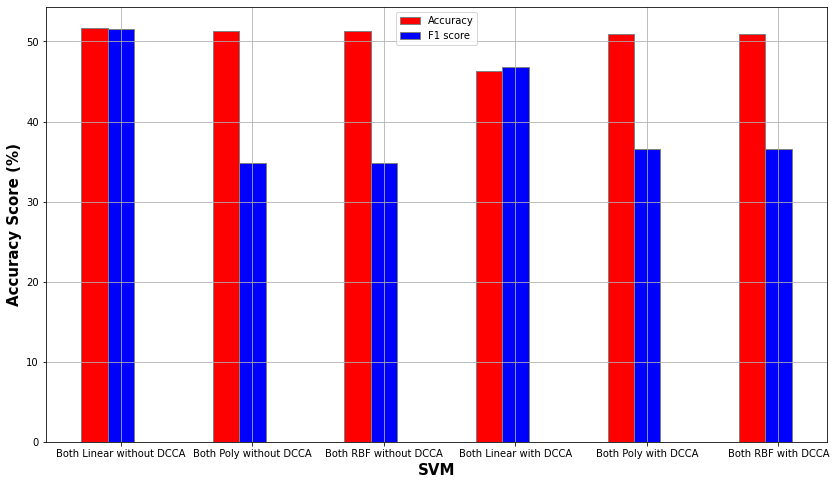

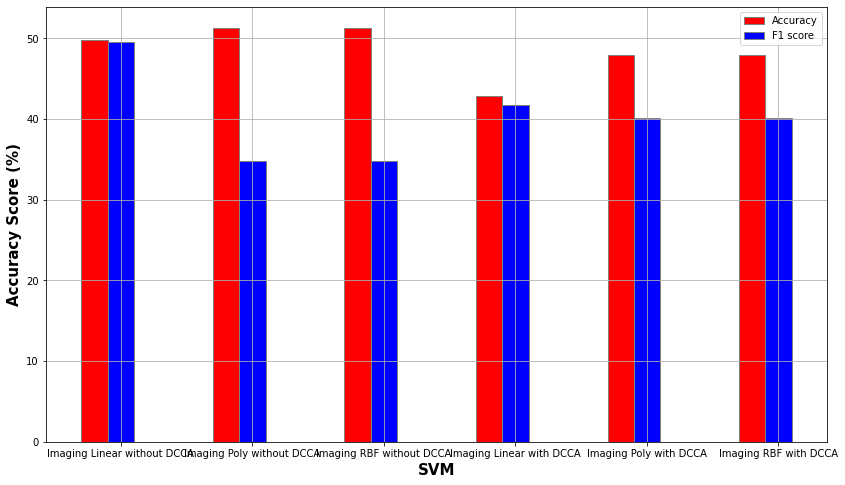

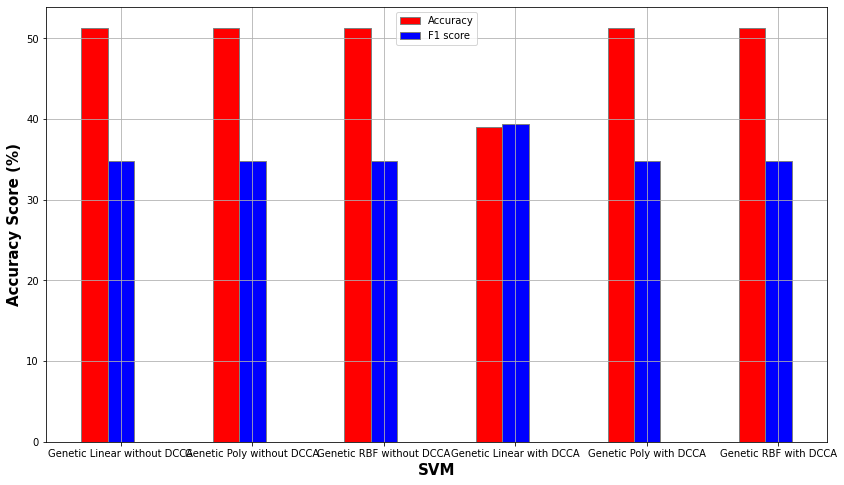

In [7]:
barplot_scores(Accuracies[0:6], F1s[0:6], 
               ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
                'Both Poly with DCCA', 'Both RBF with DCCA'])
barplot_scores(Accuracies[6:12], F1s[6:12], 
               ['Imaging Linear without DCCA', 'Imaging Poly without DCCA', 'Imaging RBF without DCCA',
                'Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA'])
barplot_scores(Accuracies[12:18], F1s[12:18], 
               ['Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 
                'Genetic Linear with DCCA','Genetic Poly with DCCA', 'Genetic RBF with DCCA'])

### Confusion Matrices:

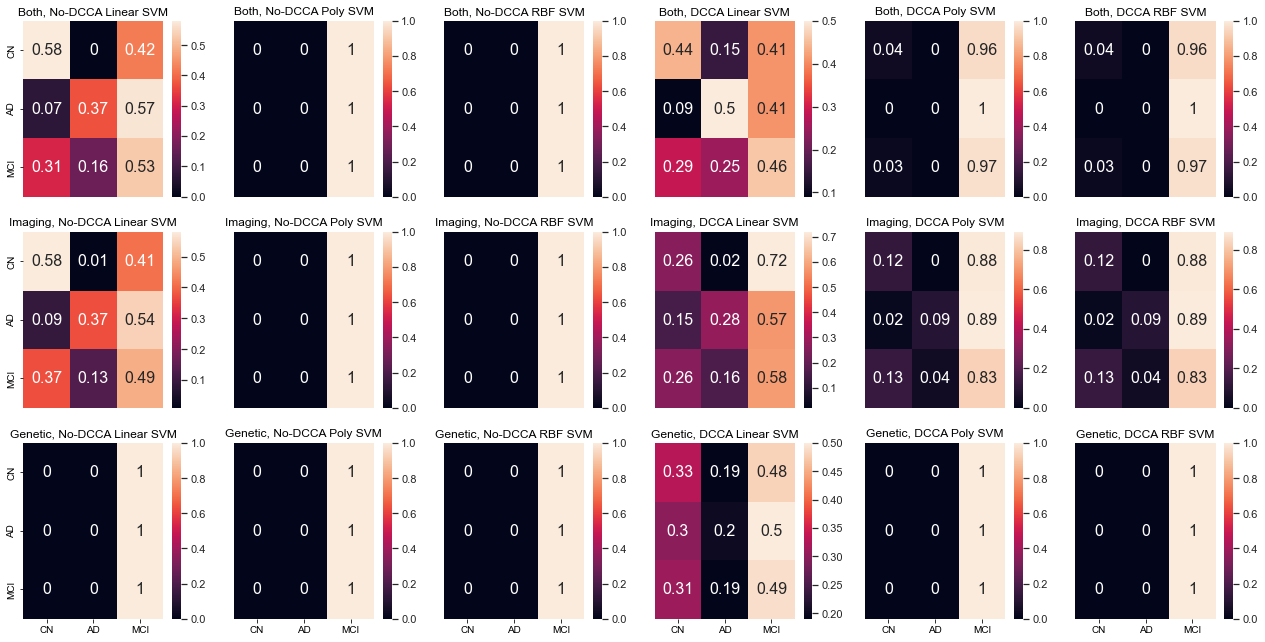

In [8]:
fig, axes = plt.subplots(nrows=3,ncols=6,figsize=(22,11));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Both, No-DCCA Linear SVM")
sns.heatmap(poly_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA Poly SVM")
sns.heatmap(rbf_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Linear SVM")
sns.heatmap(poly_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Poly SVM")
sns.heatmap(rbf_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA RBF SVM")
###
sns.heatmap(lin_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Imaging, No-DCCA Linear SVM")
sns.heatmap(poly_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Linear SVM")
sns.heatmap(poly_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA RBF SVM")
###
sns.heatmap(lin_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Genetic, No-DCCA Linear SVM")
sns.heatmap(poly_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][3], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Linear SVM")
sns.heatmap(poly_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][4], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][5], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA RBF SVM")
plt.show()


## Try with balancing & scaling:

In [11]:
# Scale the data:
scaler = preprocessing.StandardScaler()
dcca_data_scaled = scaler.fit_transform(dcca_data[imaging_labels])

dcca_data[imaging_labels] = dcca_data_scaled
dcca_data[genetic_labels].head()
# Balance the data through Undersampling - Use the same indexes as the LR Data:
dcca_data = dcca_data.loc[dcca_data['PTID'].isin(lr_data['PTID'])]

def undersample(df, ylabel='Diagnosis_nearest_2.0'):
    classes = df[ylabel].value_counts().to_dict() # specific to this dataset
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[ylabel] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

dcca_data_usampled = undersample(dcca_data)
dcca_data_usampled = dcca_data_usampled.sort_values('PTID', ascending=True)
dcca_data_usampled.reset_index(drop=True, inplace=True)

print(dcca_data_usampled['Diagnosis_nearest_2.0'].value_counts())
print(dcca_data_usampled.shape)
dcca_data_usampled.head(10)

dcca_data = dcca_data_usampled
print(dcca_data.shape)
dcca_data.head(10)

CN          243
Dementia    243
MCI         243
Name: Diagnosis_nearest_2.0, dtype: int64
(729, 310)
(729, 310)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,...,imaging_component_141,imaging_component_142,imaging_component_143,imaging_component_144,imaging_component_145,imaging_component_146,imaging_component_147,imaging_component_148,imaging_component_149,imaging_component_150
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,...,0.285303,-1.322700,1.113954,0.017703,-1.108379,0.950037,1.220310,1.010109,-1.313687,-1.506058
1,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,...,0.135458,-1.315507,1.107375,0.132013,-1.184913,0.816865,1.179632,1.060127,-1.258410,-1.042286
2,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,...,0.335125,-1.296326,0.981288,0.143269,-1.184770,0.873652,0.929216,1.339163,-1.249411,-1.736782
3,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,...,0.506879,1.328711,-0.973814,-0.067754,1.327412,-1.850755,-1.559940,-1.457648,1.239372,2.281727
4,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,...,0.220541,-1.150881,1.044151,0.259753,-1.342659,0.922712,0.977129,1.160155,-0.960054,-0.937523
5,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1,...,0.013912,-1.181937,0.987142,0.140015,-1.217194,0.678287,1.119570,1.238970,-1.064205,-0.903123
6,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1,...,-0.091206,-1.225430,1.015634,0.155477,-1.201348,0.735097,1.139846,1.198502,-1.149892,-0.903945
7,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1,...,0.220973,-1.150726,1.044384,0.259986,-1.343052,0.922961,0.976773,1.159766,-0.959781,-0.937788
8,002_S_1018,002_S_1018_2006-11-29,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,1,...,-0.019266,-1.192930,1.001762,0.138881,-1.217655,0.675942,1.107836,1.226857,-1.078329,-0.889810
9,002_S_1070,002_S_1070_2006-11-28,2006-11-28,73.564384,0,1550701.375,0.0,E3/E3,MCI,2,...,0.180043,-1.161577,1.035671,0.251108,-1.328976,0.907911,0.986347,1.185753,-0.983328,-0.925951


### Perform Classification using SVMs:

In [12]:
Accuracies = []
F1s = []
Balanced_Accuracies = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

l, p, r = svm.LinearSVC(dual=False,max_iter=2000), svm.SVC(), svm.SVC()
l_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
p_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'degree':[2,3,4,5],
            'coef0':[0.0,10.0,100.0,1000.0],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
r_params = {'C': [0.00001, 0.001, 0.01, 0.1, 1, 10], 
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

    
##############################################################################  IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns + genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):

lin_accuracy, lin_f1, lin_cm, lin_bal_acc= perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm, poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm, rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

############################################################################## IMAGING + GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_i, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_i , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_i , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_i, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d_i , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d_i , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

##############################################################################  GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = lr_data[genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_g, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_g , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_g , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

############################################################################## GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_g, lin_bal_acc = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d_g , poly_bal_acc = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d_g , rbf_bal_acc = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1
Balanced_Accuracies += lin_bal_acc, poly_bal_acc, rbf_bal_acc

names = ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
         'Both Poly with DCCA', 'Both RBF with DCCA', 'Imaging Linear without DCCA', 'Imaging Poly without DCCA',
         'Imaging RBF without DCCA','Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA',
         'Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 'Genetic Linear with DCCA',
         'Genetic Poly with DCCA', 'Genetic RBF with DCCA']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

#################### IMAGING + GENETIC: ####################
Best Parameters for untrained data ( linear  kernel): {'C': 0.01}
Accuracy (linear Kernel):  51.72
Balanced Accuracy (linear Kernel):  49.32
F1 (linear Kernel):  51.51
Best Parameters for untrained data ( poly  kernel): {'C': 1e-05, 'coef0': 0.0, 'degree': 2, 'gamma': 0.0001}
Accuracy (poly Kernel):  51.34
Balanced Accuracy (poly Kernel):  33.33
F1 (poly Kernel):  34.83
Best Parameters for untrained data ( rbf  kernel): {'C': 1e-05, 'gamma': 0.0001}
Accuracy (rbf Kernel):  51.34
Balanced Accuracy (rbf Kernel):  33.33
F1 (rbf Kernel):  34.83
#################### IMAGING + GENETIC DCCA: ####################
Best Parameters for untrained data ( linear  kernel): {'C': 0.0001}
Accuracy (linear Kernel):  40.41
Balanced Accuracy (linear Kernel):  41.01
F1 (linear Kernel):  39.99
Best Parameters for untrained data ( poly  kernel): {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 0.0001}
Accuracy (poly Kernel):  37.67
Balanced Accuracy (

### Visualizing the results:

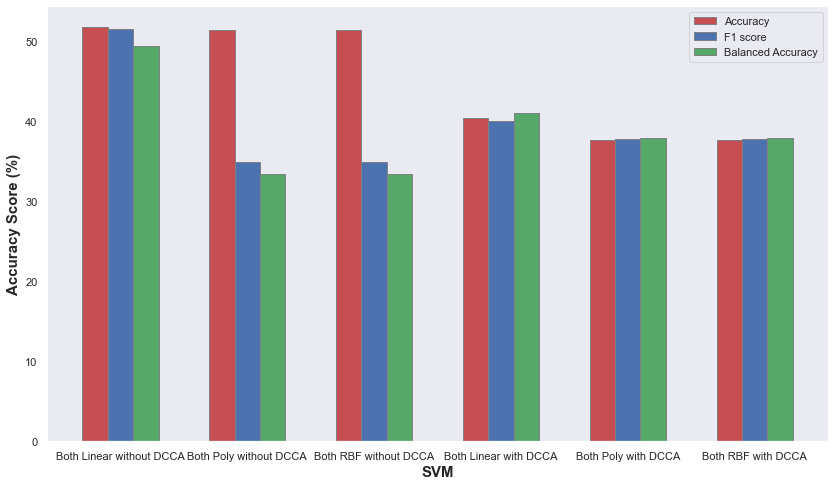

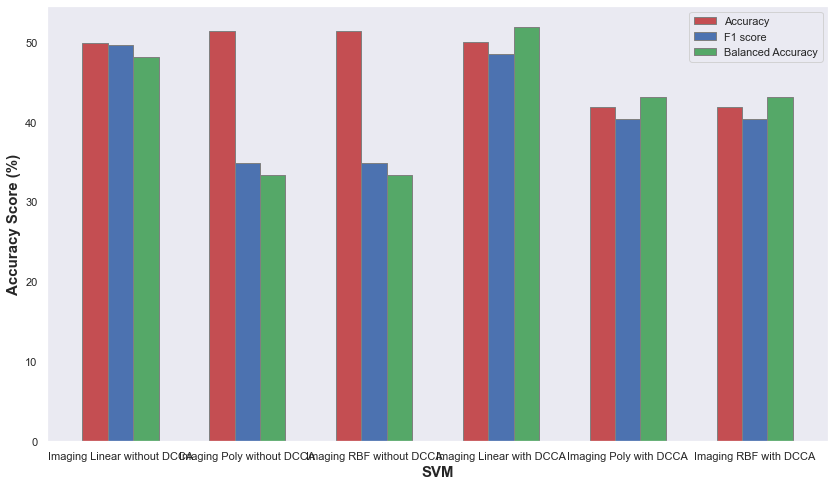

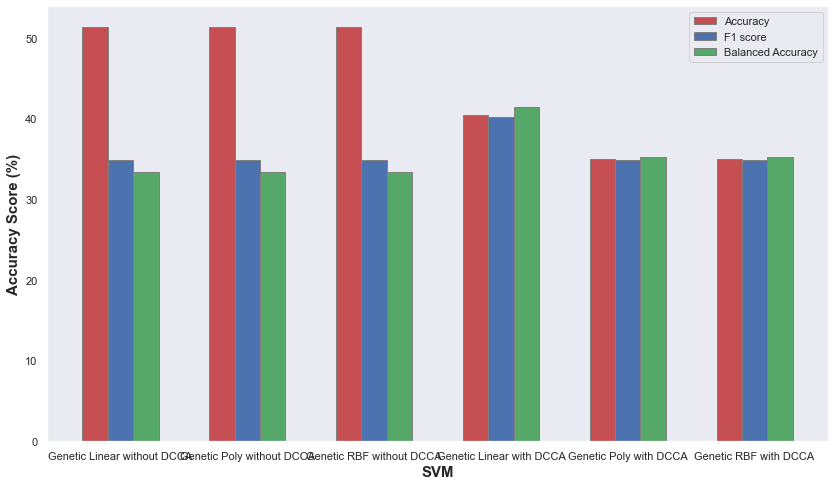

In [13]:
barplot_scores(Accuracies[0:6], F1s[0:6],
               ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
                'Both Poly with DCCA', 'Both RBF with DCCA'],
               Bal_Accuracies = Balanced_Accuracies[0:6])
barplot_scores(Accuracies[6:12], F1s[6:12],  
               ['Imaging Linear without DCCA', 'Imaging Poly without DCCA', 'Imaging RBF without DCCA',
                'Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA'],
               Bal_Accuracies = Balanced_Accuracies[6:12])
barplot_scores(Accuracies[12:18], F1s[12:18],
               ['Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 
                'Genetic Linear with DCCA','Genetic Poly with DCCA', 'Genetic RBF with DCCA'],
               Bal_Accuracies = Balanced_Accuracies[12:18])

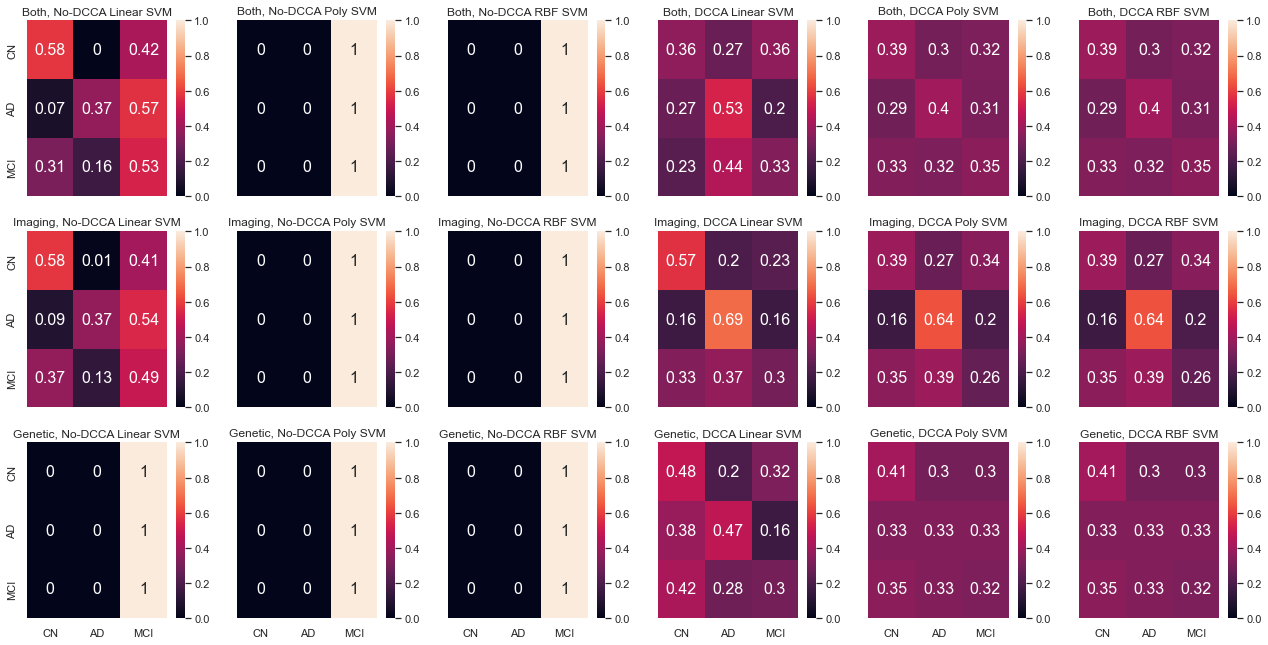

In [14]:
# Test size is 186

fig, axes = plt.subplots(nrows=3,ncols=6,figsize=(22,11));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Both, No-DCCA Linear SVM")
sns.heatmap(poly_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA Poly SVM")
sns.heatmap(rbf_cm, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Linear SVM")
sns.heatmap(poly_cm_d, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Poly SVM")
sns.heatmap(rbf_cm_d, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[0][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA RBF SVM")
###
sns.heatmap(lin_cm_i, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Imaging, No-DCCA Linear SVM")
sns.heatmap(poly_cm_i, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_i, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_i, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Linear SVM")
sns.heatmap(poly_cm_d_i, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_i, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[1][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA RBF SVM")
###
sns.heatmap(lin_cm_g, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2][0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Genetic, No-DCCA Linear SVM")
sns.heatmap(poly_cm_g, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2][1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_g, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2][2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_g, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2][3], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Linear SVM")
sns.heatmap(poly_cm_d_g, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2][4], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_g, vmin=0.0, vmax=1.0, annot=True, annot_kws={"size": 16}, ax = axes[2][5], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA RBF SVM")
plt.show()